In [15]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import itertools
import math

In [2]:
class MaskedLM(nn.Module):
    def __init__(self, num_codes, embed_dim=256, num_heads=8, hidden_dim=512, num_layers=4, dropout=0.1):
        super(MaskedLM, self).__init__()
        self.embedding = nn.Embedding(num_codes, embed_dim)
        
        self.pos_encoder = PositionalEncoding(embed_dim, dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.output_layer = nn.Linear(embed_dim, num_codes)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        logits = self.output_layer(x)
        return logits

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

def train_model(model, dataloader, vocab_size, mask_token_id, pad_token_id=0, epochs=20, 
                lr=5e-4, device="cuda", patience=3):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience//2, factor=0.5)
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    
    best_loss = float('inf')
    no_improve_count = 0
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0
        total_correct = 0
        total_tokens = 0
        
        for batch in dataloader:
            masked_inputs, labels = mask_tokens(
                batch.clone(), vocab_size, mask_token_id, pad_token_id
            )
            masked_inputs = masked_inputs.to(device)
            labels = labels.to(device)
            
            logits = model(masked_inputs)
            loss = loss_fn(logits.view(-1, vocab_size), labels.view(-1))
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            preds = logits.argmax(dim=-1)
            mask = labels != -100
            correct = (preds == labels) & mask
            total_correct += correct.sum().item()
            total_tokens += mask.sum().item()
            
            total_loss += loss.item()
            num_batches += 1
        
        avg_loss = total_loss / num_batches
        accuracy = total_correct / total_tokens if total_tokens > 0 else 0.0
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        
        scheduler.step(avg_loss)
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            no_improve_count = 0
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                break

In [3]:
def mask_tokens(inputs, vocab_size, mask_token_id, pad_token_id=0, mlm_probability=0.15):
    labels = inputs.clone()

    probability_matrix = torch.full(labels.shape, mlm_probability)
    probability_matrix.masked_fill_(inputs == pad_token_id, 0.0)
    
    masked_indices = torch.bernoulli(probability_matrix).bool()
    
    labels[~masked_indices] = -100
    
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = mask_token_id
    
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_tokens = torch.randint(1, vocab_size-1, labels.shape, dtype=torch.long, device=inputs.device)
    inputs[indices_random] = random_tokens[indices_random]
    
    
    return inputs, labels

In [27]:
def compute_embedding_similarity(model, id2icd):
    weight_matrix = model.embedding.weight.detach().cpu()

    weight_matrix_norm = F.normalize(weight_matrix, p=2, dim=1)
    similarity = torch.mm(weight_matrix_norm, weight_matrix_norm.t())

    valid_indices = list(range(1, len(id2icd) - 1))
    codes = [id2icd[i] for i in valid_indices]

    similarity_df = pd.DataFrame(
        similarity.numpy()[1:-1, 1:-1],
        index=codes,
        columns=codes
    )

    return similarity_df

In [5]:
class ICDDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = [torch.tensor(s, dtype=torch.long) for s in sequences]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

def collate_fn(batch):
    return pad_sequence(batch, batch_first=True, padding_value=0)

In [6]:
df = pd.read_csv('prepared_data.csv', index_col=0)
df = df.sort_values(["subject_id", "admittime", "seq_num"])
df['seq_num'] = df.groupby('subject_id').cumcount() + 1

unique_icds = df["category"].unique()
print(f"Уникальных ICD кодов: {len(unique_icds)}")

Уникальных ICD кодов: 1757


In [7]:
df.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,icd10_code,icd10_category,admittime,dischtime,deathtime,is_oncology,category
0,10000032,22595853,1,5723,9,K766,K76,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,0,K76
1,10000032,22595853,2,78959,9,R188,R18,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,0,R18
2,10000032,22595853,3,5715,9,K740,K74,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,0,K74
3,10000032,22595853,4,07070,9,B1920,B19,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,0,B19
4,10000032,22595853,5,496,9,J449,J44,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,0,J44


In [8]:
PAD_TOKEN_ID = 0
icd2id = {code: idx for idx, code in enumerate(unique_icds, start=1)}
MASK_TOKEN_ID = len(icd2id) + 1
icd2id["[MASK]"] = MASK_TOKEN_ID

In [9]:
vocab_size = len(icd2id) + 1

print(f"Размер словаря: {vocab_size}")
print(f"PAD token ID: {PAD_TOKEN_ID}")
print(f"MASK token ID: {MASK_TOKEN_ID}")
print(f"ICD codes range: 1 - {len(unique_icds)}")

Размер словаря: 1759
PAD token ID: 0
MASK token ID: 1758
ICD codes range: 1 - 1757


In [10]:
id2icd = {idx: code for code, idx in icd2id.items()}
id2icd[PAD_TOKEN_ID] = "[PAD]"

In [11]:
df = df[['subject_id', 'seq_num', 'category']]
sequences = df.groupby("subject_id")["category"].apply(list).tolist()

max_len = 100
min_len = 5

trimmed_sequences = [seq[:max_len] for seq in sequences]
seq_idx = [[icd2id[code] for code in seq] for seq in trimmed_sequences]
seq_idx = [seq for seq in seq_idx if len(seq) >= min_len]

print(f"Количество последовательностей после фильтрации: {len(seq_idx)}")

Количество последовательностей после фильтрации: 187089


In [13]:
dataset = ICDDataset(seq_idx)
dataloader = DataLoader(dataset, batch_size=64, collate_fn=collate_fn, shuffle=True)

In [16]:
model = MaskedLM(vocab_size)

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Используется устройство: cuda


In [18]:
train_model(
    model, dataloader, vocab_size, MASK_TOKEN_ID, 
    pad_token_id=PAD_TOKEN_ID, epochs=20, lr=5e-4, device=device
)

Epoch 1/20, Loss: 5.0626, Accuracy: 0.1080
Epoch 2/20, Loss: 4.5878, Accuracy: 0.1526
Epoch 3/20, Loss: 4.4235, Accuracy: 0.1730
Epoch 4/20, Loss: 4.3191, Accuracy: 0.1855
Epoch 5/20, Loss: 4.2389, Accuracy: 0.1975
Epoch 6/20, Loss: 4.1687, Accuracy: 0.2076
Epoch 7/20, Loss: 4.1075, Accuracy: 0.2175
Epoch 8/20, Loss: 4.0515, Accuracy: 0.2261
Epoch 9/20, Loss: 3.9979, Accuracy: 0.2335
Epoch 10/20, Loss: 3.9469, Accuracy: 0.2411
Epoch 11/20, Loss: 3.9196, Accuracy: 0.2454
Epoch 12/20, Loss: 3.8800, Accuracy: 0.2512
Epoch 13/20, Loss: 3.8469, Accuracy: 0.2553
Epoch 14/20, Loss: 3.8175, Accuracy: 0.2602
Epoch 15/20, Loss: 3.7998, Accuracy: 0.2629
Epoch 16/20, Loss: 3.7703, Accuracy: 0.2667
Epoch 17/20, Loss: 3.7499, Accuracy: 0.2702
Epoch 18/20, Loss: 3.7315, Accuracy: 0.2729
Epoch 19/20, Loss: 3.7129, Accuracy: 0.2748
Epoch 20/20, Loss: 3.6963, Accuracy: 0.2769


In [28]:
similarity = compute_embedding_similarity(model, id2icd)

In [31]:
similarity

,K76,R18,K74,B19,J44,F31,F43,Z87,D69,E87,Z21,F17,I95,B18,R64,Z66,Z99,K52,F10,G31,F02,R44,R29,E78,Z85,R41,G20,R60,K12,K02,R13,R09,K31,K21,K44,F41,I34,M81,S72,W01,...,B51,A30,F59,K67,G02,H75,H67,J64,W37,B79,Q91,T16,A65,V74,A82,V42,E76,X13,X73,Z70,W52,A91,E42,V37,A23,B41,X34,P29,X17,A83,V45,V16,W99,P11,B56,W85,P07,A27,Y64,Y21
K76,1.000000,0.037286,-0.139314,0.030739,0.061125,-0.056584,-0.046857,-0.008661,0.062071,0.031610,-0.063992,-0.055236,-0.052586,-0.034307,0.036310,0.026052,-0.094193,-0.012619,0.005831,-0.004491,0.058556,-0.110570,0.011192,0.039633,-0.041014,0.016459,-0.104419,-0.021959,-0.015072,0.087773,0.177799,-0.034787,0.159186,0.053686,-0.009336,-0.020182,0.035323,-0.001358,-0.019094,-0.094615,...,0.081120,0.041910,0.066476,-0.081786,0.102235,-0.097327,-0.041142,-0.004183,0.031557,-0.036484,-0.021662,0.033995,-0.100267,-0.022025,0.009342,-0.082525,0.058189,-0.028323,0.198856,-0.015491,0.004341,0.009148,0.021339,0.099125,-0.039322,-0.058891,0.020510,0.004112,-0.152806,0.027451,-0.016519,-0.015791,0.039260,-0.022507,0.020056,0.041265,-0.013206,-0.089645,-0.067003,-0.041003
R18,0.037286,1.000000,-0.077715,0.086276,-0.133544,-0.018843,0.044567,-0.019297,0.094231,0.026878,0.125862,-0.049448,-0.022973,0.120533,-0.034228,-0.019340,-0.006299,0.022853,-0.006705,0.070847,0.055610,0.001221,0.151377,0.059812,-0.005781,-0.072793,0.023256,-0.078997,-0.037939,0.086232,-0.016814,-0.038378,-0.089171,-0.088259,-0.019060,0.074525,0.093260,-0.080128,-0.064417,-0.000689,...,-0.065384,0.036584,-0.101500,0.014775,0.010434,-0.014726,-0.112302,-0.013845,0.059822,-0.064016,0.039492,-0.076229,-0.062519,-0.012263,-0.008305,0.056969,0.058868,-0.055440,0.029101,0.034037,-0.012244,-0.038485,0.050838,0.021675,-0.044078,0.036540,-0.065067,0.030088,-0.137035,-0.027225,0.051554,0.011331,0.051270,-0.037043,-0.170789,-0.011409,0.050091,0.031272,-0.075029,0.094283
K74,-0.139314,-0.077715,1.000000,0.001034,0.132329,0.007132,0.052991,0.038699,0.092542,0.036709,0.060698,-0.081837,0.021109,-0.020695,0.019901,-0.092824,-0.124081,0.039725,0.102959,-0.128883,-0.010112,-0.061344,0.003597,-0.080242,-0.016844,-0.028062,0.056817,-0.076570,0.017524,0.034943,-0.036790,-0.060716,0.076211,-0.138008,0.048288,-0.043203,0.034352,-0.124401,0.071455,0.046123,...,-0.081585,-0.111576,0.090905,0.075773,0.098776,-0.074719,-0.051414,0.011646,0.066308,-0.060697,0.075365,0.094835,0.053109,0.080821,0.047868,-0.000103,0.008669,0.047240,0.041204,-0.003698,-0.027040,-0.044587,-0.021131,-0.025413,0.027914,-0.011329,0.001552,0.022849,0.027812,0.023925,0.033475,0.065028,-0.024733,0.070800,0.005683,-0.048808,-0.047571,-0.056380,0.045860,0.022726
B19,0.030739,0.086276,0.001034,1.000000,-0.078733,0.081823,0.089614,-0.030483,0.087073,0.052550,0.034142,0.052420,-0.021378,0.132117,0.084520,0.041295,-0.011306,-0.001364,-0.012789,-0.016601,-0.105638,-0.040228,-0.086441,0.056398,0.038443,-0.003815,0.054672,-0.021506,0.019356,0.064267,0.070513,0.014262,0.036615,0.015313,0.003081,-0.037173,-0.028254,-0.003201,-0.018353,-0.056241,...,-0.023492,-0.013070,-0.034055,0.043286,-0.026056,0.001741,-0.003615,-0.066481,0.015775,0.014902,0.023977,0.007961,-0.029838,-0.036936,-0.032877,-0.030686,0.009971,0.027264,0.094583,-0.037512,0.039763,0.134955,-0.071293,-0.029448,-0.016415,0.000972,0.036887,-0.084088,-0.030885,0.039636,0.039613,0.007187,-0.066214,-0.074156,0.008833,0.002352,0.019035,0.008496,0.043292,-0.006928
J44,0.061125,-0.133544,0.132329,-0.078733,1.000000,-0.034519,-0.096522,-0.009462,-0.058668,0.020591,-0.038007,0.001605,-0.013800,-0.088633,-0.039777,0.001954,0.062057,-0.024714,0.008912,-0.089302,0.091794,-0.004308,-0.058577,0.043528,-0.004251,0.001711,0.028427,-0.120681,-0.033845,-0.090904,0.103466,-0.044576,0.089597,0.045497,0.026217,-0.007963,-0.009338,-0.001051,0.101943,-0.024549,...,0.029228,0.037417,0.040222,-0.010491,-0.023523,-0.022768,0.103228,0.025287,0.022592,-0.072483,-0.063078,-0.061779,0.046824,0.112987,0.091844,0.030186,0.054781,-0.013695,0.008539,0.013848,0.049361,0.095739,-0.061989,-

In [32]:
similarity.to_csv("mlm_results.csv")

In [24]:
len(similarity)

1542646

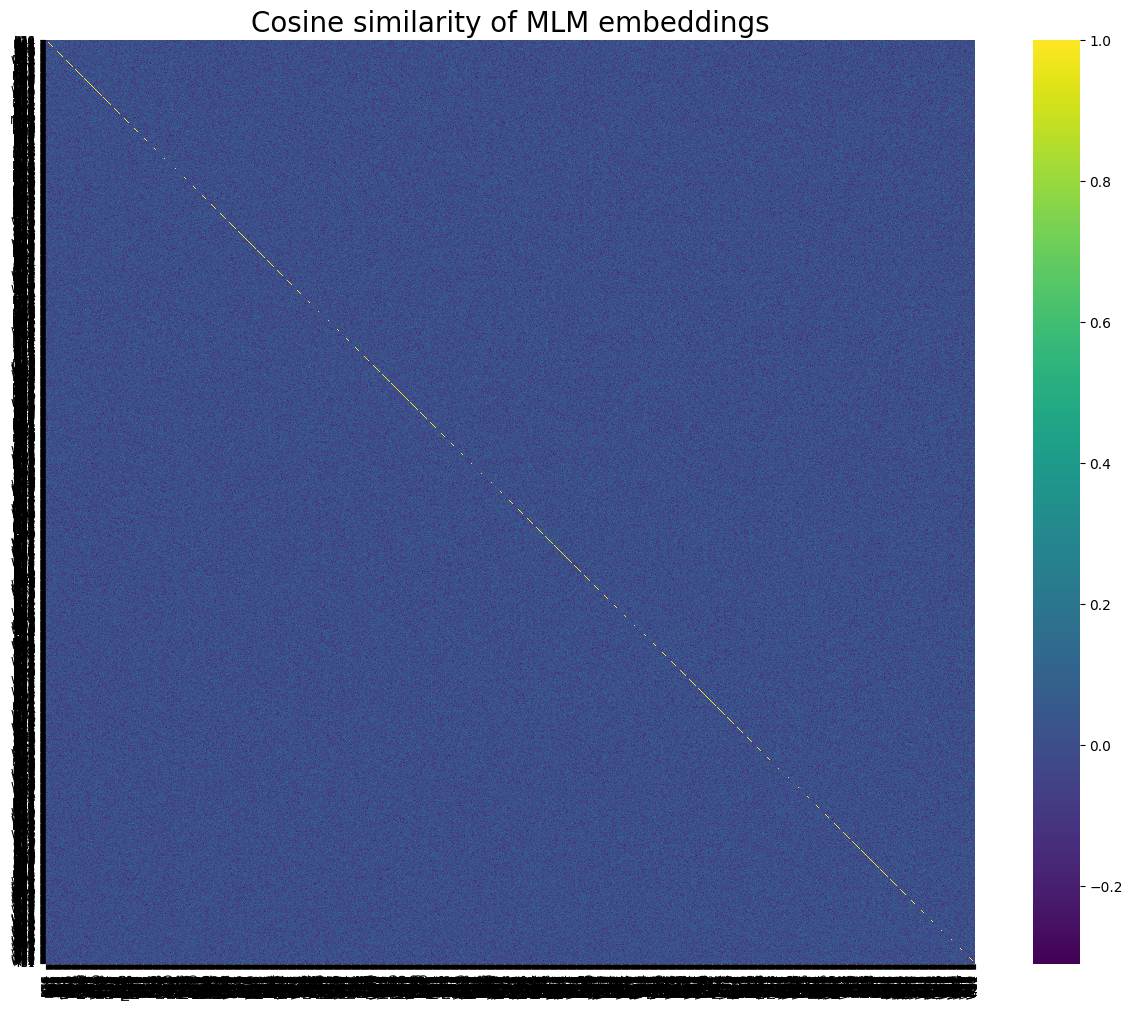

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

name = "Cosine similarity of MLM embeddings"

plt.figure(figsize=(15,12))
sns.heatmap(similarity, annot=False, cmap="viridis")
plt.title(name, fontsize=20)
plt.savefig(f'mlm.jpg', dpi=300, bbox_inches='tight')

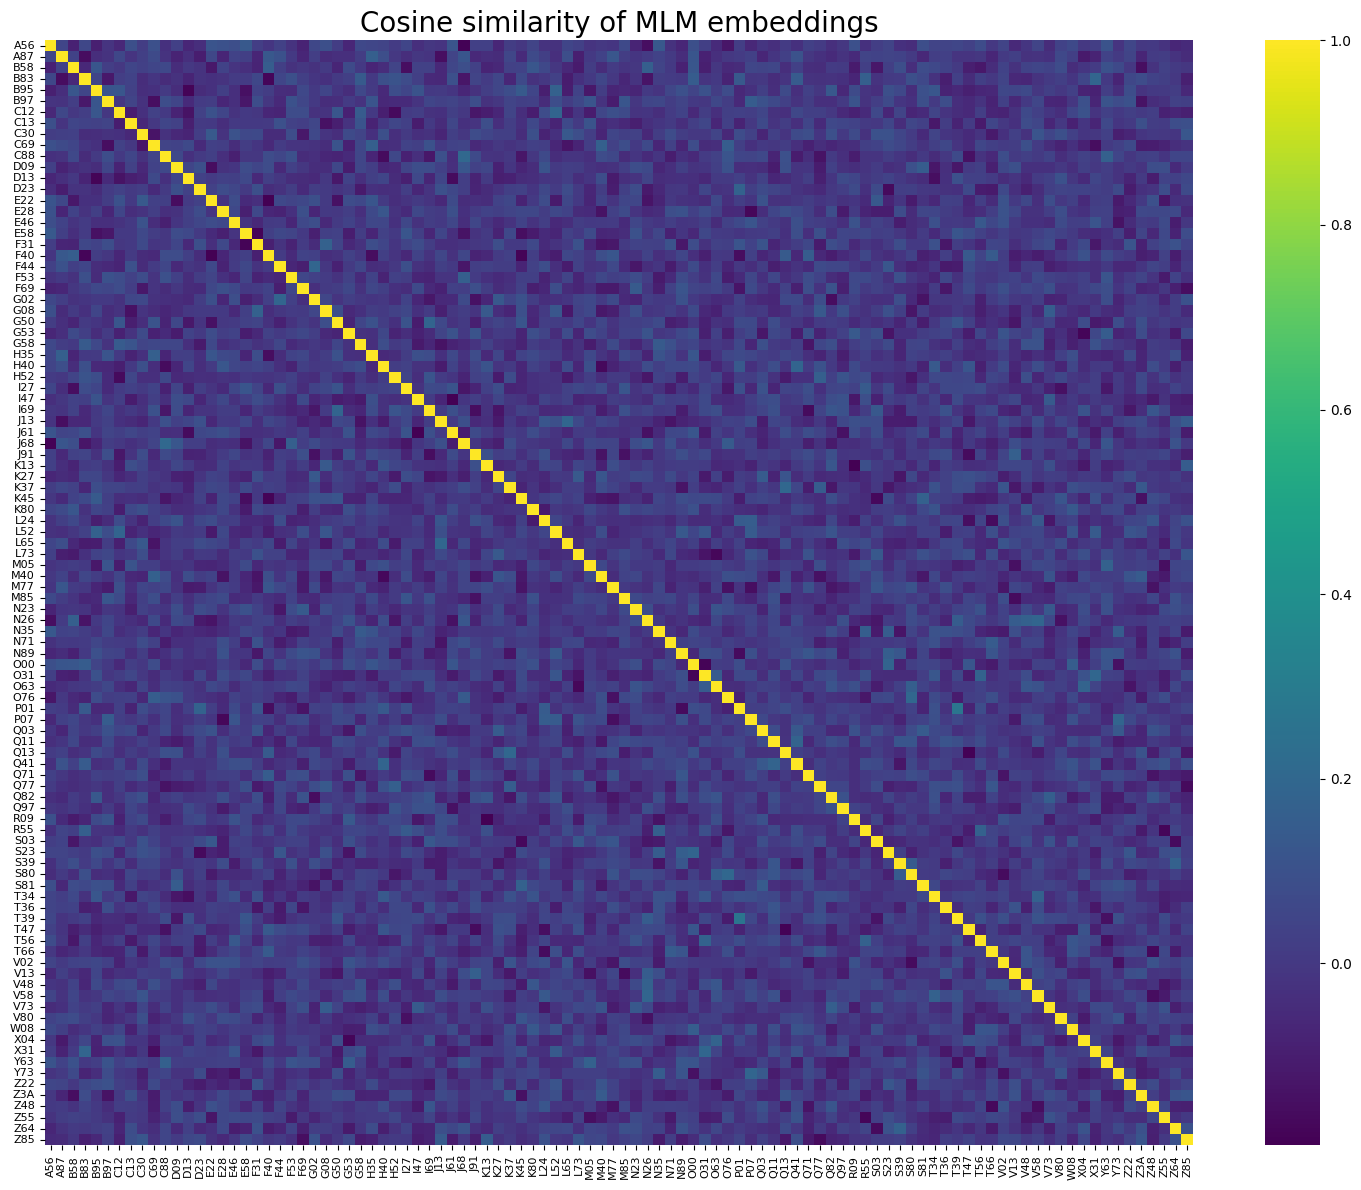

In [53]:
N = 100
name = "Cosine similarity of MLM embeddings"
diag_values = np.diag(similarity)
top_indices = np.argsort(diag_values)[::-1][:N]
top_cats = [id2icd[i] for i in top_indices]

top_cats_sorted = sorted(top_cats, reverse=False)

top_co_df = similarity.loc[top_cats_sorted, top_cats_sorted]
                          
plt.figure(figsize=(15,12))
sns.heatmap(top_co_df, annot=False, cmap="viridis", xticklabels=True, yticklabels=True)
plt.title(name, fontsize=20)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.savefig(f'mlm_{N}.jpg', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [44]:
def top_n_pairs(similarity_df, n=10):
    df_long = similarity_df.stack().reset_index()
    df_long.columns = ["icd_1", "icd_2", "similarity"]

    df_long = df_long[df_long["icd_1"] != df_long["icd_2"]]

    df_long = df_long[df_long["icd_1"] < df_long["icd_2"]]

    df_top = df_long.sort_values("similarity", ascending=False).head(n)
    return df_top

In [45]:
top_10 = top_n_pairs(similarity, n=10)
print(top_10)

        icd_1 icd_2  similarity
1509923   C32   M40    0.351683
614418    I75   X79    0.299272
1606927   E61   K13    0.296837
135387    I48   N39    0.293801
701611    D70   F25    0.290977
1386076   C94   J63    0.284889
907268    I81   L30    0.276681
1485193   W00   Z94    0.276080
2122008   E75   I88    0.273941
2507078   D07   P01    0.268234
